In [1]:
import spacy

# Load small English model
nlp = spacy.load("en_core_web_sm")

# Add sentencizer for splitting sentences
nlp.add_pipe("sentencizer")


In [2]:
import warnings
warnings.filterwarnings("ignore", message=r"\[W108\]")


In [12]:
#Loading the discharge CSV
import os

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath('')))  # optional but safe
DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'mimic_iv', 'note')
discharge_path = os.path.join(DATA_DIR, 'discharge.csv')

print(discharge_path)


C:\Users\krish\MIMIC\data\mimic_iv\note\discharge.csv


In [4]:
DATA_DIR = os.path.join('..', 'data', 'mimic_iv', 'note')
discharge_path = os.path.join(DATA_DIR, 'discharge.csv')


In [5]:
import pandas as pd

df_discharge = pd.read_csv(discharge_path, nrows=10000)
df_discharge.head()


,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000032-DS-21,10000032,22595853,DS,21,2180-05-07 00:00:00,2180-05-09 15:26:00,\nName: ___ Unit No: _...
1,10000032-DS-22,10000032,22841357,DS,22,2180-06-27 00:00:00,2180-07-01 10:15:00,\nName: ___ Unit No: _...
2,10000032-DS-23,10000032,29079034,DS,23,2180-07-25 00:00:00,2180-07-25 21:42:00,\nName: ___ Unit No: _...
3,10000032-DS-24,10000032,25742920,DS,24,2180-08-07 00:00:00,2180-08-10 05:43:00,\nName: ___ Unit No: _...
4,10000084-DS-17,10000084,23052089,DS,17,2160-11-25 00:00:00,2160-11-25 15:09:00,\nName: ___ Unit No: __...


In [6]:
#Cleaning the text
import re

def clean_text(text):
    if pd.isna(text):
        return ""
    
    # Remove MIMIC PHI markers [** ... **]
    text = re.sub(r"\[\*\*.*?\*\*\]", " ", text)
    
    # Remove template headers: match any line that starts with a key word + colon
    # Add common MIMIC headers like Date of Birth, Allergies, etc.
    headers = [
        "Name", "Unit No", "Admission Date", "Discharge Date", "Age", 
        "Sex", "MRN", "Service", "Attending", "Date of Birth", "Allergies"
    ]
    # Create regex pattern: ^(Header1|Header2|...):.*
    pattern = r"^(" + "|".join(headers) + r"):.*"
    text = re.sub(pattern, "", text, flags=re.MULTILINE)
    
    # Remove multiple spaces/newlines
    text = re.sub(r"\s+", " ", text)
    
    return text.strip()

# Apply
df_discharge['clean_text'] = df_discharge['text'].apply(clean_text)

# Preview
df_discharge['clean_text'].head()


0    No Known Allergies / Adverse Drug Reactions Ch...
1    Percocet Chief Complaint: abdominal fullness a...
2    Percocet / Vicodin Chief Complaint: altered me...
3    Percocet / Vicodin Chief Complaint: Abdominal ...
4    No Known Allergies / Adverse Drug Reactions Ch...
Name: clean_text, dtype: object

In [7]:
#Sentence splitting
texts = df_discharge['clean_text'].tolist()
sentences_list = []

for doc in nlp.pipe(texts, batch_size=50, disable=["ner", "tagger", "parser"]):
    # Only do sentence segmentation
    sents = [s.text.strip() for s in doc.sents if len(s.text.strip()) > 10]
    sentences_list.append(sents)

df_discharge['sentences'] = sentences_list


In [8]:
#Keyword extraction (simple approach)
from sklearn.feature_extraction.text import TfidfVectorizer

# Use top 50 words as risk factors
vectorizer = TfidfVectorizer(max_features=50, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_discharge['clean_text'])
keywords = vectorizer.get_feature_names_out()
print("Top keywords:", keywords)


Top keywords: ['10' '100' '11' '12' '20' '30' '___' 'acute' 'admission' 'bid' 'blood'
 'chest' 'clear' 'ct' 'daily' 'day' 'discharge' 'disp' 'exam' 'follow'
 'given' 'glucose' 'hct' 'hgb' 'history' 'home' 'hospital' 'instructions'
 'left' 'medication' 'medications' 'mg' 'neg' 'normal' 'pain' 'past'
 'patient' 'physical' 'plt' 'po' 'prior' 'prn' 'pt' 'rbc' 'refills'
 'right' 'sig' 'status' 'tablet' 'wbc']


In [10]:
from wordcloud import WordCloud
print("WordCloud imported successfully!")


WordCloud imported successfully!


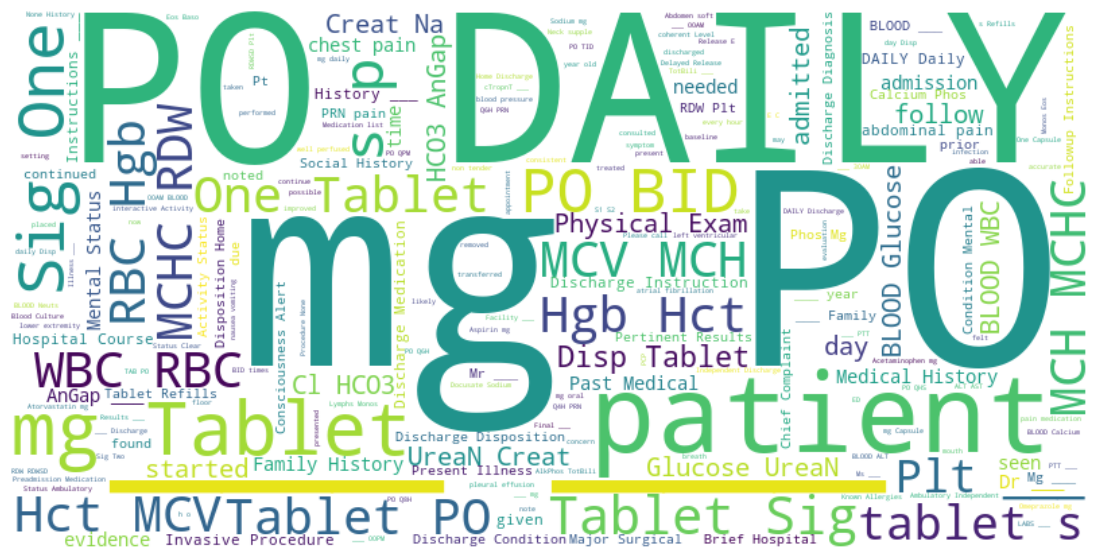

In [11]:
#Word cloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all text
all_text = " ".join(df_discharge['clean_text'].tolist())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [13]:
#Topic clustering (more “intellectual”)
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000, stop_words='english')
dt_matrix = vectorizer.fit_transform(df_discharge['clean_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dt_matrix)

for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    print([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])


Topic 1:
['denies', 'normal', 'daily', 'neg', 'discharge', 'po', 'history', 'mg', 'patient', '___']
Topic 2:
['chest', 'patient', 'normal', 'right', 'blood', 'left', 'daily', 'po', 'mg', '___']
Topic 3:
['blood', 'pain', 'capsule', 'po', 'day', 'daily', 'mg', 'sig', '___', 'tablet']
Topic 4:
['history', '10', 'patient', 'pain', 'daily', 'discharge', 'po', 'mg', 'blood', '___']
Topic 5:
['tablet', 'history', 'medications', 'daily', 'patient', 'discharge', 'po', 'pain', 'mg', '___']


In [14]:
#Saving processed results
results_dir = os.path.join(os.getcwd(), 'results')
os.makedirs(results_dir, exist_ok=True)

df_discharge.to_csv(os.path.join(results_dir, 'discharge_processed.csv'), index=False)
